In [1]:
import torch
import numpy as np
from scipy.integrate import solve_ivp
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:

def matrix_riccati_ode(t, S, H, M, D_inv, C):
    S = S.reshape((H.shape[0], H.shape[1]))
    dS_dt = -2 * H.T @ S + S @ M @ D_inv @ M.T @ S - C
    return dS_dt.reshape(-1)

class LQR:
    def __init__(self, H, M, sigma, C, R, D, T):
        self.H = H
        self.M = M
        self.sigma = sigma
        self.C = C
        self.R = R
        self.D = D
        self.T = T

    def solve(self, t, t_eval = None):
        D_inv = np.linalg.inv(self.D)
        if t == self.T:
            return None, None
        if t is None:
            t = 0
        if t_eval is None:
            t_eval = np.linspace(self.T, t, 101)
        sol = solve_ivp(matrix_riccati_ode, (self.T, t), self.R.reshape(-1), t_eval = t_eval, method='RK45', args=(self.H, self.M, D_inv, self.C))
        return sol.t, sol.y.reshape((-1, self.H.shape[0], self.H.shape[1]))  # Reshape solution to matrix form

    def getValue(self, ts, data):
        batch_size = data.shape[0]
        values = torch.zeros((batch_size, 1))
        for i in range(batch_size):
            t = ts[i]
            x = data[i][0].numpy()
            n = 101
            ts, sols = self.solve(t, np.linspace(self.T, t, n))
            values[i][0] = x.T @ sols[-1] @ x
            for sol in sols:
                values[i][0] += abs(self.T - t) / n * np.trace(self.sigma @ self.sigma.T @ sol)
        return values

    def getMarkovControl(self, ts, data):
        batch_size = data.shape[0]
        values = torch.zeros((batch_size, 2))
        for i in range(batch_size):
            t = ts[i]
            x = data[i][0].numpy()
            n = 101
            ts, sols = self.solve(t, np.linspace(self.T, t, n))
            values[i] = torch.from_numpy(-self.D @ self.M.T @ sols[-1] @ x)
        return values

    
    def runMonteCarlo(self, num_steps, num_samples, x):
        res = []
        dt = self.T / num_steps
        ts = np.linspace(0, self.T, num_steps)
        for i in range(num_samples):
            cur_x = np.array(x).reshape(-1,1)
            for j in range(num_steps - 1):
                increments = np.random.normal(0, 1, (1,2)).T
                _, S_tn = self.solve(ts[j])
                S_tn = S_tn[-1]
                cur_x = cur_x + dt * (self.H @ cur_x - self.M @ self.D @ S_tn @ cur_x) + self.sigma @ increments
            res.append(cur_x)
        return res


In [3]:
# Example usage:
H = np.array([[0, 1], [0, 0]])
M = np.array([[1, 0], [0, 1]])
D = np.array([[1, 0], [0, 1]])
T = 10
R = np.array([[1, 0], [0, 1]])
C = np.array([[0, 0], [0, 0]])
sigma = np.array([[0.2, 0], [0, 0.4]])
lqr = LQR(H, M, sigma, C, R, D, T)

t, p = lqr.solve(1, [10, 9, 8,7,6,5,4,3,2,1])

In [4]:
print(t)
print(p)

[10  9  8  7  6  5  4  3  2  1]
[[[1.         0.50004522]
  [0.33340164 0.25023873]]

 [[0.20020319 0.16691877]
  [0.14303641 0.12527806]]

 [[0.11134773 0.10019216]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.74966365]
  [0.88844408 0.93666871]]

 [[0.9593791  0.97155337]
  [0.97911555 0.98381892]]

 [[0.98719542 0.98963225]
  [1.         0.50004522]]

 [[0.33340164 0.25023873]
  [0.20020319 0.16691877]]

 [[0.14303641 0.12527806]
  [0.11134773 0.10019216]]]


In [5]:
ts = torch.tensor([1, 2])
x = torch.tensor([[[2,1]], [[3,2]]])

In [6]:
print(t.shape)

(10,)


In [7]:
lqr.getValue(ts, x)

tensor([[ 1.5519],
        [22.9790]])

In [8]:
lqr.getMarkovControl(ts, x)

tensor([[-0.3080, -0.3024],
        [-4.5970, -4.5894]])

From the above code, we define the class LQR with attribute 'H, M, sigma, C, R, D, T', which is mentioned in the definition of LQR. The class has three methods - solve, getValue, getMarkovControl. 'Solve' will solve the associated Ricatti ODE on a time grid. 'getValue' will return the control problem value $v(t,x)$. 'getMarkovControl' will return the Markov control function.

We can choose MSE for error measure and we write following codes to show log-log plot.

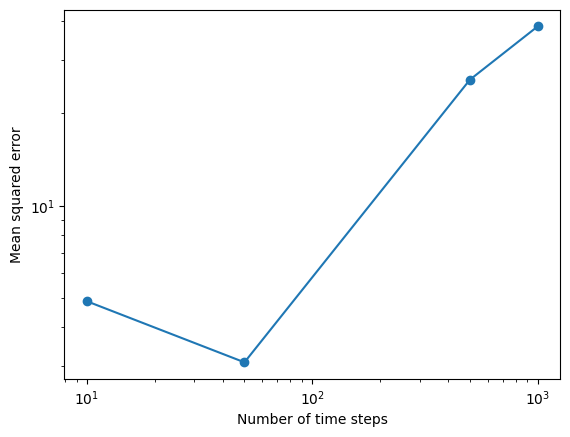

In [19]:
import matplotlib.pyplot as plt


#note that a much larger number of samples and time steps were considered but due to computational considerations,
# we have had to settle for the following

# Set number of Monte Carlo samples
num_samples = 50

# Set different numbers of time steps to simulate
num_steps_list = [10, 50, 500, 1000]

# Initialize list to store MSE for each number of time steps
mse_list = []

# initial value of x
x = [1, 2]

# Loop over different numbers of time steps and compute MSE
for num_steps in num_steps_list:
    # Run Monte Carlo simulation
    # Here, we assume that the simulation returns the estimated value function as a numpy array
    # and the true value function as a dictionary with state-value pairs
    x_rets = lqr.runMonteCarlo(num_steps, num_samples, x)
    _, x_true = lqr.solve(0)
    x_true = x_true[-1]
    
    # Compute MSE
    mse = np.mean([np.linalg.norm(x_ret - x_true)**2 for x_ret in x_rets])
    
    # Append MSE to list
    mse_list.append(mse)


plt.loglog(num_steps_list, mse_list, '-o')
plt.xlabel('Number of time steps')
plt.ylabel('Mean squared error')
plt.show()


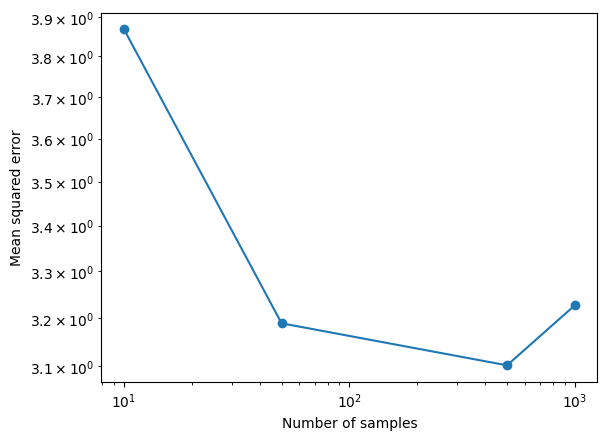

In [17]:
#note that a much larger number of samples and time steps were considered but due to computational considerations,
# we have had to settle for the following

# Set number of Monte Carlo samples
num_samples_list = [10, 50, 500, 1000]

# Set different numbers of time steps to simulate
num_steps = 50

# Initialize list to store MSE for each number of time steps
mse_list = []

# initial value of x
x = [1, 2]

# Loop over different numbers of time steps and compute MSE
for num_samples in num_samples_list:
    # Run Monte Carlo simulation
    # Here, we assume that the simulation returns the estimated value function as a numpy array
    # and the true value function as a dictionary with state-value pairs
    x_rets = lqr.runMonteCarlo(num_steps, num_samples, x)
    _, x_true = lqr.solve(0)
    x_true = x_true[-1]
    
    # Compute MSE
    mse = np.mean([np.linalg.norm(x_ret - x_true)**2 for x_ret in x_rets])
    
    # Append MSE to list
    mse_list.append(mse)


plt.loglog(num_samples_list, mse_list, '-o')
plt.xlabel('Number of samples')
plt.ylabel('Mean squared error')
plt.show()


## Ex2
Take the neural network [1, Net DGM class] with hidden layer size of 100.

With T = 1, use Exercise 1.1 to generate training data v(t(i),x(i)) by sampling t uniformly on [0, T ] and x uniformly on [−3, 3] × [3, 3].

In [ ]:
lqr.getValue()

In [34]:
ts = torch.tensor([0, 1])
x = torch.tensor([[[-3,3]], [[3,3]]])
lqr.getValue(ts, x)

tensor([[ 0.6928],
        [32.7821]])

tensor([[1.5519]])